# LSTM

In [1]:
# util.py has pmdarima function inside
# Need to install it before import the pyfile
!pip install pmdarima

     |████████████████████████████████| 1.5MB 12.9MB/s 
     |████████████████████████████████| 9.5MB 64.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [78]:
# Google Colab
from google.colab import drive
import os

# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pickle import dump, load

# Scikit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Keras, Tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

## Goole Colab Setup

In [3]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
# Get the current working directory
print(os.getcwd())

/content


In [5]:
# Drive path is the path where I upload the ETFs history file and pre-written pyfile
drive_path_csv = '/gdrive/MyDrive/Capstone_Project/REIT_ETFs.csv'
drive_path_util = '/gdrive/MyDrive/Capstone_Project/util.py'

# Expect to move these file into the local path
local_path = '/content'

In [6]:
# Copy these file in drive path
!cp '{drive_path_csv}' .
!cp '{drive_path_util}' .

# Change these file from drive path to the local path
os.chdir(local_path)

In [7]:
# Pre-written function
import util as ut

## Preprocesing

In [8]:
data = pd.read_csv('/content/REIT_ETFs.csv')
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
1,2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2,2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
3,2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
4,2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...,...
53434,2021-06-17,9.280000,9.290000,9.220000,9.220000,5200,0.0,0.0,REK
53435,2021-06-18,9.330000,9.370000,9.270000,9.370000,22800,0.0,0.0,REK
53436,2021-06-21,9.320000,9.320000,9.170000,9.170000,22900,0.0,0.0,REK
53437,2021-06-22,9.160000,9.230000,9.160000,9.220000,6200,0.0,0.0,REK


In [10]:
# Select one REIT ETF
vnq = data.copy().loc[data['Ticker'] == "VNQ"]

In [11]:
# Preprocess the dataframe
ut.preprocess_df(vnq)

This dataframe's index is in datatime 64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...
2021-06-17,103.410004,103.699997,102.860001,103.550003,5055100,0.0,0.0,VNQ
2021-06-18,103.019997,103.470001,101.790001,101.790001,5358000,0.0,0.0,VNQ
2021-06-21,102.309998,104.209999,101.800003,103.889999,3672900,0.0,0.0,VNQ


In [12]:
# Split the data into train, validation, and test set
# Test size = 1 month (22 days)
# Val size = 1 year (253 days)
# Train size = rest of the time
train = vnq['Close'].iloc[:-275]
val = vnq['Close'].iloc[-275:-22]
test = vnq['Close'].iloc[-22:]

In [13]:
print("Train: date from {} to {}, total of {} days".format(train.index[0],train.index[-1], len(train)))
print("Val: date from {} to {}, total of {} days".format(val.index[0],val.index[-1], len(val)))
print("Test: date from {} to {}, total of {} days".format(test.index[0],test.index[-1], len(test)))

Train: date from 2004-09-29 00:00:00 to 2020-05-20 00:00:00, total of 3938 days
Val: date from 2020-05-21 00:00:00 to 2021-05-21 00:00:00, total of 253 days
Test: date from 2021-05-24 00:00:00 to 2021-06-23 00:00:00, total of 22 days


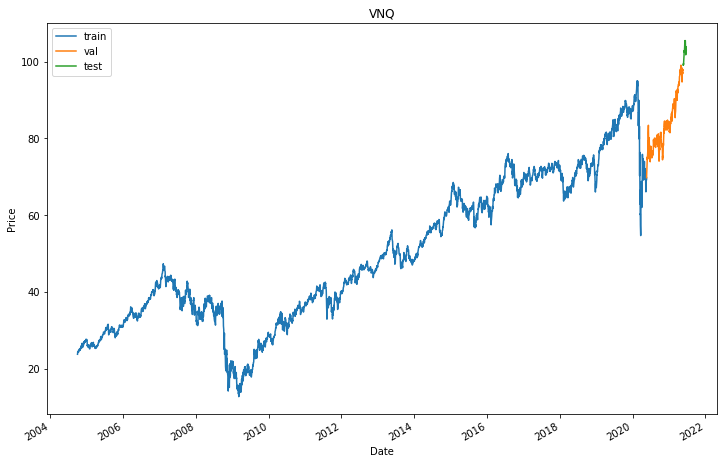

In [16]:
plt.figure(figsize=(12,8))
train.plot()
val.plot()
test.plot()
plt.title("VNQ")
plt.ylabel("Price")
plt.legend(['train', 'val', 'test'])
plt.show()

In [17]:
# Scale the data
scaler = MinMaxScaler()

train_scale = scaler.fit_transform(train.values.reshape(-1,1))
val_scale = scaler.transform(val.values.reshape(-1,1))
test_scale = scaler.transform(test.values.reshape(-1,1))

In [18]:
# Save the scaler
dump(scaler, open('/content/scaler.pkl', 'wb'))

# Load the scaler (if run in another notebook)
# sc = load(open('/content/scaler.pkl', 'rb'))

In [19]:
def xy_split (dataset, timestep):
    '''
    Split the time series into X and y part based on the number of timestep.
    Ex. Use n days to predict the next preceding day (n+1) price.
    
    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

    Inputs:
    - dataset: Time series data
    - timestep: number of days in integer
    
    Return: 
    - X_part, y_part (in arrays)
    '''
    
    X_part, y_part = [], []
    
    for i in range(len(dataset)-timestep-1):
         
        X_part.append(dataset[i:(i+timestep)])

        y_part.append(dataset[i+timestep])

    return np.array(X_part), np.array(y_part)

## Modeling

### Functions

In [79]:
def model_evaluation(model, X_train, y_train, X_val, y_val):
    '''
    Evaluate the LSTM model by using  prediction of y based on X.
    Inverse transform both the prediction y and actual y. 
    
    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

    Inputs:
    - model: Time series model name
    - X_train, y_train, X_val, y_val
    
    Outpus:
    - Evalution results for true y and predicted y
        - MAE, RMSE, and R^2
    
    Return:
    - y_val_true, y_val_inv

    '''
    
    # Make prediction
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Inverse transform the prediction and actual
    y_train_inv = scaler.inverse_transform(y_train_pred) # prediction
    y_val_inv = scaler.inverse_transform(y_val_pred) # prediction

    y_train_true = scaler.inverse_transform(y_train) # actual
    y_val_true =scaler.inverse_transform(y_val) # actual
    
    # Use the evalute function from util pyfile
    print("Train results: ")
    print(ut.evaluate(y_train_true, y_train_inv))
    print("\n")
    print("Val results: ")
    print(ut.evaluate(y_val_true, y_val_inv))

    return y_val_true, y_val_inv

In [80]:
def plot_prediction(y_true, y_pred):
    '''
    Comparison plot of actual y and predicted y.

    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
    
    Inputs:
    - y_true, y_pred: true y and predicted y
    
    Outpus:
    - Scatter plot of true y and line plot of predicted y
    '''

    plt.figure(figsize=(20,10))
    plt.plot(y_true, '.')
    plt.plot(y_pred)
    plt.legend(['Actual', 'Predicted'])
    plt.show()

### Baseline Model

### t1 u50

In [20]:
# X,y split with timestep of 1
X_train, y_train = xy_split(train_scale, timestep=1)
X_val, y_val = xy_split(val_scale, timestep=1)
X_test, y_test = xy_split(test_scale, timestep=1)

In [21]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (3936, 1, 1)
y_train shape:  (3936, 1)
X_val shape:  (251, 1, 1)
y_val shape:  (251, 1)
X_test shape:  (20, 1, 1)
y_test shape:  (20, 1)


https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM

### Early Stopping
- prevent over training

In [22]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)

In [23]:
# Build the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1:])))
model.add(LSTM(50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


### Check Point
- Save the best model when val_loss of MSE reaches minimum

In [25]:
# Model Checkpoint
mc = ModelCheckpoint(filepath='/content/t1_u50.h5',
                     monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [26]:
# Fit the model
model.fit(X_train, y_train, batch_size=23, epochs=50,
          validation_data=(X_val, y_val),
          callbacks=[es, mc])

Epoch 1/50
172/172 [==============================] - 4s 6ms/step - loss: 0.0527 - val_loss: 0.0018

Epoch 00001: val_loss improved from inf to 0.00175, saving model to /content/t1_u50.h5
Epoch 2/50
172/172 [==============================] - 1s 3ms/step - loss: 6.0331e-04 - val_loss: 0.0014

Epoch 00002: val_loss improved from 0.00175 to 0.00135, saving model to /content/t1_u50.h5
Epoch 3/50
172/172 [==============================] - 0s 3ms/step - loss: 3.5016e-04 - val_loss: 0.0013

Epoch 00003: val_loss improved from 0.00135 to 0.00126, saving model to /content/t1_u50.h5
Epoch 4/50
172/172 [==============================] - 0s 3ms/step - loss: 2.7773e-04 - val_loss: 7.5164e-04

Epoch 00004: val_loss improved from 0.00126 to 0.00075, saving model to /content/t1_u50.h5
Epoch 5/50
172/172 [==============================] - 0s 3ms/step - loss: 2.1113e-04 - val_loss: 5.2304e-04

Epoch 00005: val_loss improved from 0.00075 to 0.00052, saving model to /content/t1_u50.h5
Epoch 6/50
172/172 [

In [83]:
base_y_val_true, base_y_val_inv = model_evaluation(model, X_train, y_train, X_val, y_val)

Train results: 
MAE: 0.5152
RMSE: 0.7719
R^2: 0.9983
None


Val results: 
MAE: 0.9361
RMSE: 1.1631
R^2: 0.9713
None


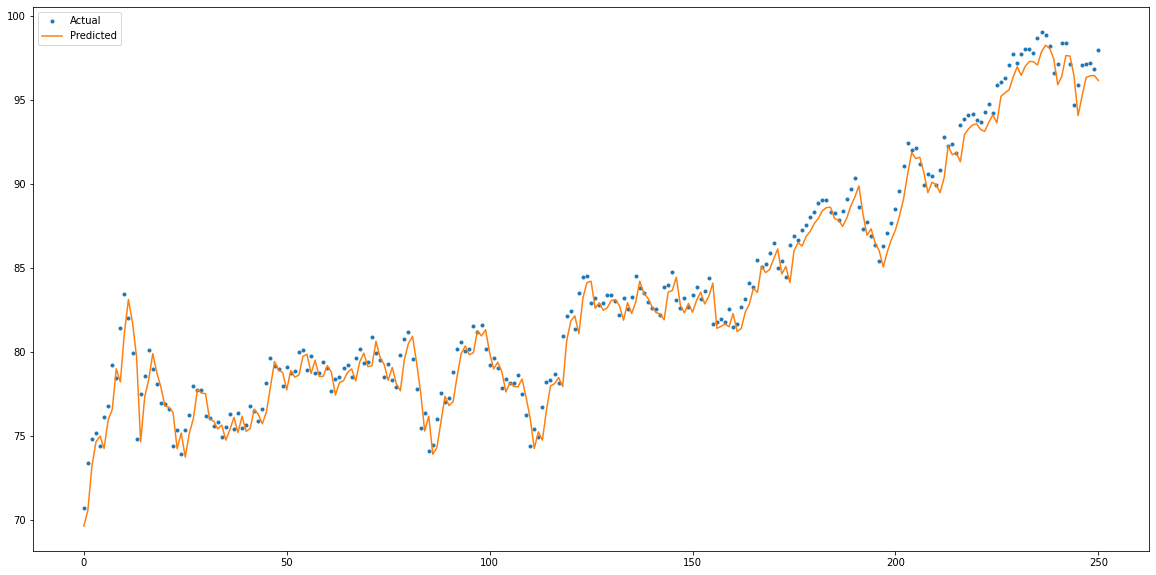

In [84]:
plot_prediction(base_y_val_true, base_y_val_inv)

- Compare the train and val r^2, no sign of overfitting

### Prediction on true holdout test set

In [34]:
# Load model (if run in another notebook)
best = load_model('/content/t1_u50.h5')

In [35]:
# Make prediction on the holdout test set
y_test_pred = best.predict(X_test)

# Inverse transform the test prediction and actual
y_test_inv = scaler.inverse_transform(y_test_pred)
y_test_true = scaler.inverse_transform(y_test)

In [36]:
ut.evaluate(y_test_true, y_test_inv)

MAE: 0.7603
RMSE: 0.9875
R^2: 0.7592


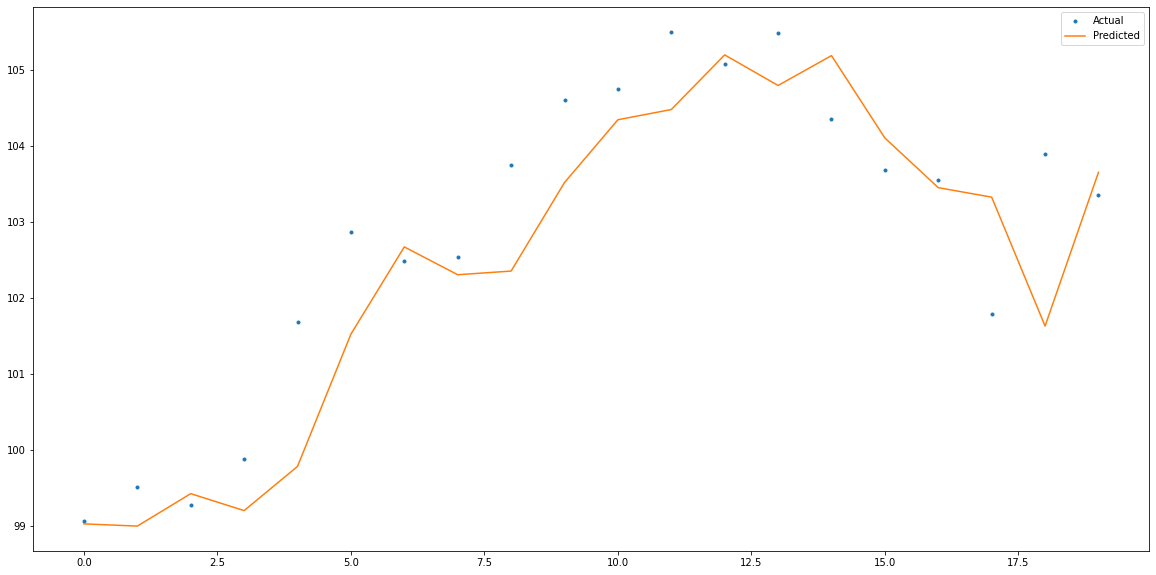

In [37]:
plot_prediction(y_test_true, y_test_inv)

### Iteration step with GridSearch

https://github.com/tirthajyoti/Deep-learning-with-Python/blob/master/Notebooks/Keras_Scikit_Learn_wrapper.ipynb

https://towardsdatascience.com/are-you-using-the-scikit-learn-wrapper-in-your-keras-deep-learning-model-a3005696ff38

In [57]:
def step_unit_model(train_set, val_set, time_step=1, unit):
    '''
    Create a LSTM model with custom timesetp and input unit.
    Applied xy_split function to split the dataset into X and y part.

    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

    Inputs:
    - train_set: train dataset
    - val_set: validation dataset
    - time_step: integer
    - unit: integer

    Return:
    - Custom model, X_train ,y_train, X_val ,y_val
    '''
    
    # X, y split
    X_train, y_train = xy_split(train_set, timestep=time_step)
    X_val, y_val = xy_split(val_set, timestep=time_step)

    # Build the model
    model = Sequential()
    model.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1:])))
    model.add(LSTM(unit))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
  
    return model, X_train, y_train, X_val, y_val

In [94]:
def unit_model(unit):
    '''
    Create a LSTM model with custom timesetp and input unit.
    Applied xy_split function to split the dataset into X and y part.

    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

    Inputs:
    - train_set: train dataset
    - val_set: validation dataset
    - time_step: integer
    - unit: integer

    Return:
    - Custom model, X_train ,y_train, X_val ,y_val
    '''
    
    # X, y split
    # X_train, y_train = xy_split(train_set, timestep=time_step)
    # X_val, y_val = xy_split(val_set, timestep=time_step)

    # Build the model
    model = Sequential()
    model.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1:])))
    model.add(LSTM(unit))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
  
    return model

In [95]:
# Wrapper
u_model = KerasRegressor(build_fn=unit_model)

In [97]:
u = [50, 100, 150, 200, 250, 300]

# Parameter grid
u_param_grid = dict(unit = u)

In [98]:
# Grid Search
u_grid = GridSearchCV(u_model, param_grid = u_param_grid, cv=3)

In [102]:
u_grid_history = u_grid.fit(X_train, y_train,
                            batch_size=23, epochs=50,
                            validation_data=(X_val, y_val),
                            callbacks=es,
                            verbose=0)

Epoch 1/50
115/115 [==============================] - 4s 8ms/step - loss: 0.0936 - val_loss: 0.0166
Epoch 2/50
115/115 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 3/50
115/115 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 5.1936e-04
Epoch 4/50
115/115 [==============================] - 0s 3ms/step - loss: 3.1422e-04 - val_loss: 7.4127e-04
Epoch 5/50
115/115 [==============================] - 0s 3ms/step - loss: 2.9674e-04 - val_loss: 0.0014
Epoch 6/50
115/115 [==============================] - 0s 3ms/step - loss: 2.7989e-04 - val_loss: 8.0404e-04
Epoch 7/50
115/115 [==============================] - 0s 3ms/step - loss: 2.6066e-04 - val_loss: 5.0369e-04
Epoch 8/50
115/115 [==============================] - 0s 3ms/step - loss: 2.5204e-04 - val_loss: 5.2032e-04
Epoch 9/50
115/115 [==============================] - 0s 3ms/step - loss: 2.4639e-04 - val_loss: 4.6404e-04
Epoch 10/50
115/115 [==============================]

In [103]:
# Find the best parameter
u_grid_history.best_params_

{'unit': 150}

## t1 u100

In [58]:
t1u100, t1u100_X_train, t1u100_y_train, t1u100_X_val, t1u100_y_val = step_unit_model(train_scale, val_scale, time_step=1, unit=100)

In [60]:
mc_t1u100 = ModelCheckpoint(filepath='/content/t1_u100.h5',
                            monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [61]:
t1u100.fit(t1u100_X_train, t1u100_y_train, batch_size=23, epochs=50,
           validation_data=(t1u100_X_val, t1u100_y_val),
           callbacks=[es, mc_t1u100])

Epoch 1/50
172/172 [==============================] - 4s 9ms/step - loss: 0.0336 - val_loss: 9.1014e-04

Epoch 00001: val_loss improved from inf to 0.00091, saving model to /content/t1_u100.h5
Epoch 2/50
172/172 [==============================] - 1s 4ms/step - loss: 2.7317e-04 - val_loss: 6.2416e-04

Epoch 00002: val_loss improved from 0.00091 to 0.00062, saving model to /content/t1_u100.h5
Epoch 3/50
172/172 [==============================] - 1s 4ms/step - loss: 2.2507e-04 - val_loss: 7.9124e-04

Epoch 00003: val_loss did not improve from 0.00062
Epoch 4/50
172/172 [==============================] - 1s 4ms/step - loss: 1.7041e-04 - val_loss: 2.9357e-04

Epoch 00004: val_loss improved from 0.00062 to 0.00029, saving model to /content/t1_u100.h5
Epoch 5/50
172/172 [==============================] - 1s 3ms/step - loss: 1.3268e-04 - val_loss: 3.1810e-04

Epoch 00005: val_loss did not improve from 0.00029
Epoch 6/50
172/172 [==============================] - 1s 4ms/step - loss: 1.0539e-04 

In [62]:
model_t1u100 = load_model('/content/t1_u100.h5')

In [68]:
def model_evaluation(model, X_train, y_train, X_val, y_val):
    '''
    '''
    # Make prediction
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Inverse transform the prediction and actual
    y_train_inv = scaler.inverse_transform(y_train_pred)
    y_val_inv = scaler.inverse_transform(y_val_pred)

    y_train_true = scaler.inverse_transform(y_train)
    y_val_true =scaler.inverse_transform(y_val)
    
    print("Train results: ")
    print(ut.evaluate(y_train_true, y_train_inv))
    print("\n")
    print("Val results: ")
    print(ut.evaluate(y_val_true, y_val_inv))

    return y_val_true, y_val_inv

## t1 u100

In [69]:
t1u100_y_val_true, t1u100_y_val_inv = model_evaluation(model_t1u100, t1u100_X_train, t1u100_y_train, t1u100_X_val, t1u100_y_val)

Train results: 
MAE: 0.5465
RMSE: 0.8117
R^2: 0.9981
None


Val results: 
MAE: 0.8234
RMSE: 1.0679
R^2: 0.9758
None


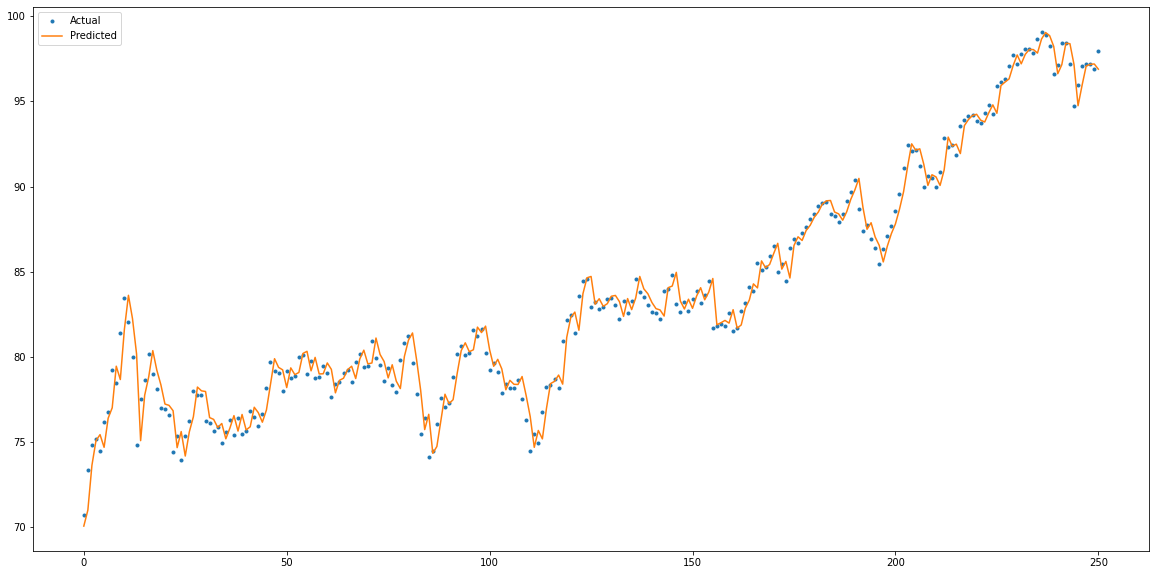

In [70]:
plot_prediction(t1u100_y_val_true, t1u100_y_val_inv)

## t1 u200

In [71]:
t1u200, t1u200_X_train, t1u200_y_train, t1u200_X_val, t1u200_y_val = step_unit_model(train_scale, val_scale, time_step=1, unit=200)

In [72]:
mc_t1u200 = ModelCheckpoint(filepath='/content/t1_u200.h5',
                            monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [73]:
t1u200.fit(t1u200_X_train, t1u200_y_train, batch_size=23, epochs=50,
           validation_data=(t1u200_X_val, t1u200_y_val),
           callbacks=[es, mc_t1u200])

Epoch 1/50
172/172 [==============================] - 4s 10ms/step - loss: 0.0231 - val_loss: 4.7020e-04

Epoch 00001: val_loss improved from inf to 0.00047, saving model to /content/t1_u200.h5
Epoch 2/50
172/172 [==============================] - 1s 7ms/step - loss: 1.7485e-04 - val_loss: 4.3568e-04

Epoch 00002: val_loss improved from 0.00047 to 0.00044, saving model to /content/t1_u200.h5
Epoch 3/50
172/172 [==============================] - 1s 7ms/step - loss: 1.4341e-04 - val_loss: 2.5619e-04

Epoch 00003: val_loss improved from 0.00044 to 0.00026, saving model to /content/t1_u200.h5
Epoch 4/50
172/172 [==============================] - 1s 7ms/step - loss: 1.2048e-04 - val_loss: 4.8132e-04

Epoch 00004: val_loss did not improve from 0.00026
Epoch 5/50
172/172 [==============================] - 1s 7ms/step - loss: 1.0415e-04 - val_loss: 2.2951e-04

Epoch 00005: val_loss improved from 0.00026 to 0.00023, saving model to /content/t1_u200.h5
Epoch 6/50
172/172 [=======================

In [74]:
model_t1u200 = load_model('/content/t1_u200.h5')

In [75]:
t1u200_y_val_true, t1u200_y_val_inv = model_evaluation(model_t1u200, t1u200_X_train, t1u200_y_train, t1u200_X_val, t1u200_y_val)

Train results: 
MAE: 0.5921
RMSE: 0.8468
R^2: 0.9980
None


Val results: 
MAE: 0.8337
RMSE: 1.0694
R^2: 0.9757
None


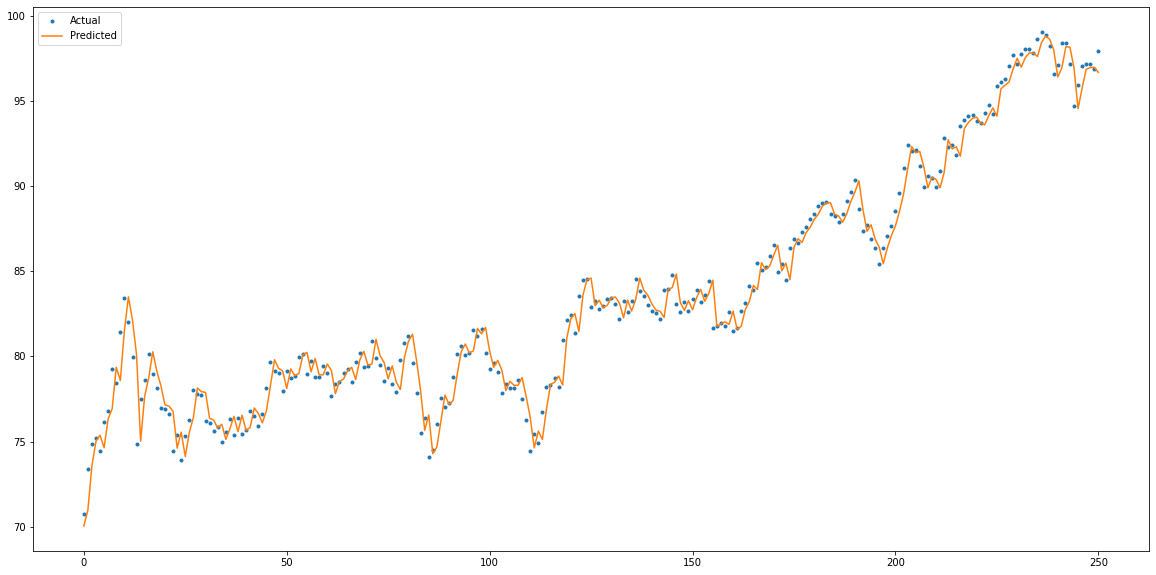

In [76]:
plot_prediction(t1u200_y_val_true, t1u200_y_val_inv)

3954/3954 [==============================] - 21s 5ms/step - loss: 0.0014


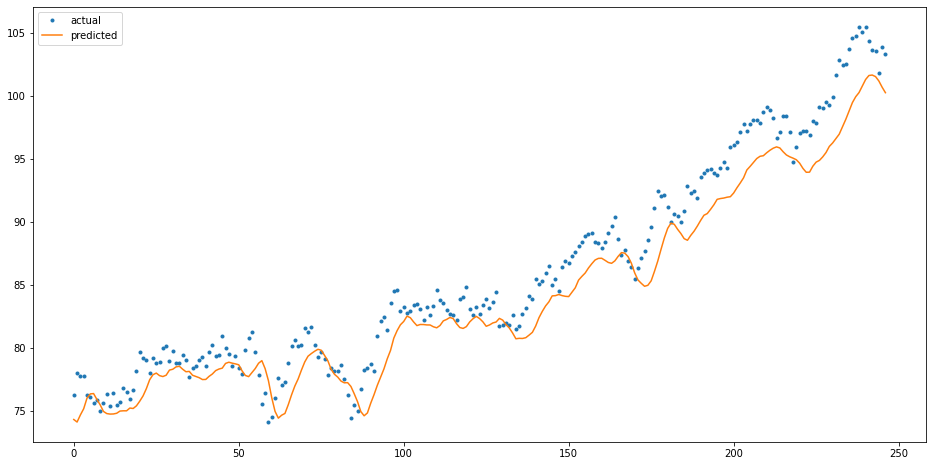

MAE: 2.1083
RMSE: 2.5022
R^2: 0.9094


In [ ]:
unit_model(train_scale, test_scale, time_step=5, unit=50)

3958/3958 [==============================] - 14s 3ms/step - loss: 0.0032


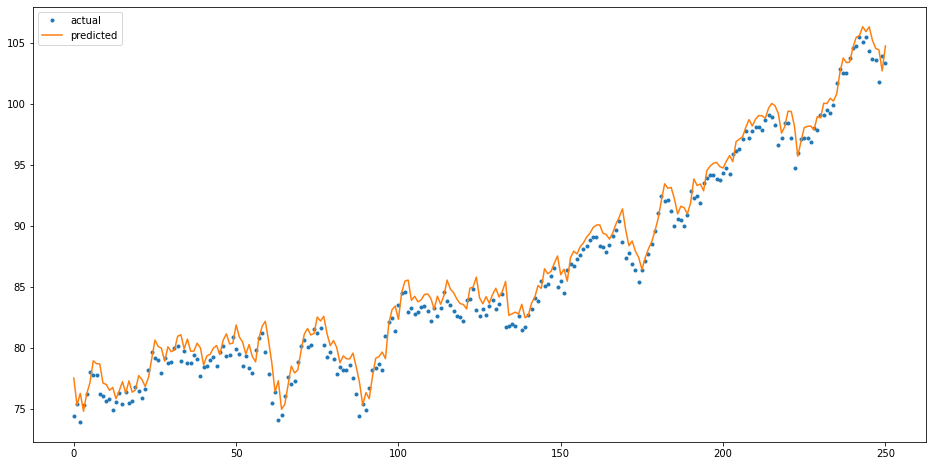

MAE: 1.0311
RMSE: 1.2788
R^2: 0.9766


In [ ]:
unit_model(train_scale, test_scale, time_step=1, unit=50)

3949/3949 [==============================] - 29s 7ms/step - loss: 9.3051e-04


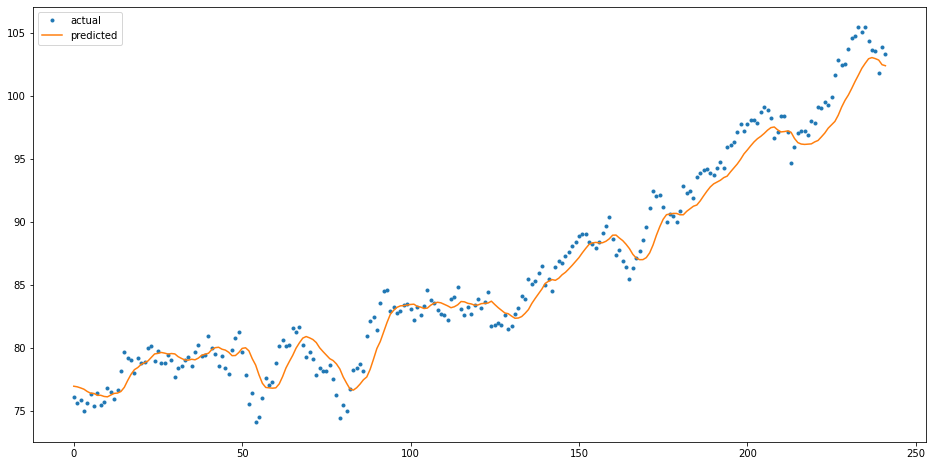

MAE: 1.3488
RMSE: 1.6874
R^2: 0.9587


In [ ]:
unit_model(train_scale, test_scale, time_step=10, unit=50)

3914/3914 [==============================] - 83s 21ms/step - loss: 0.0013


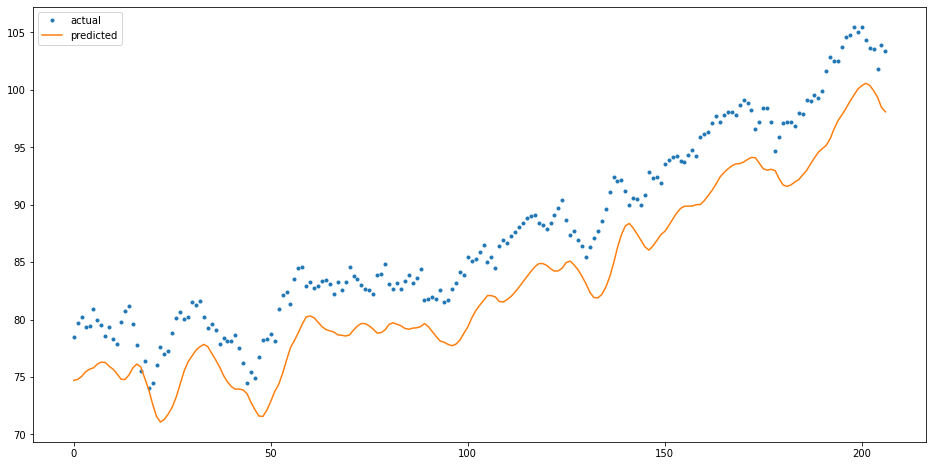

MAE: 4.4016
RMSE: 4.6159
R^2: 0.6783


In [ ]:
unit_model(train_scale, test_scale, time_step=45, unit=50)

3958/3958 [==============================] - 16s 3ms/step - loss: 0.0023


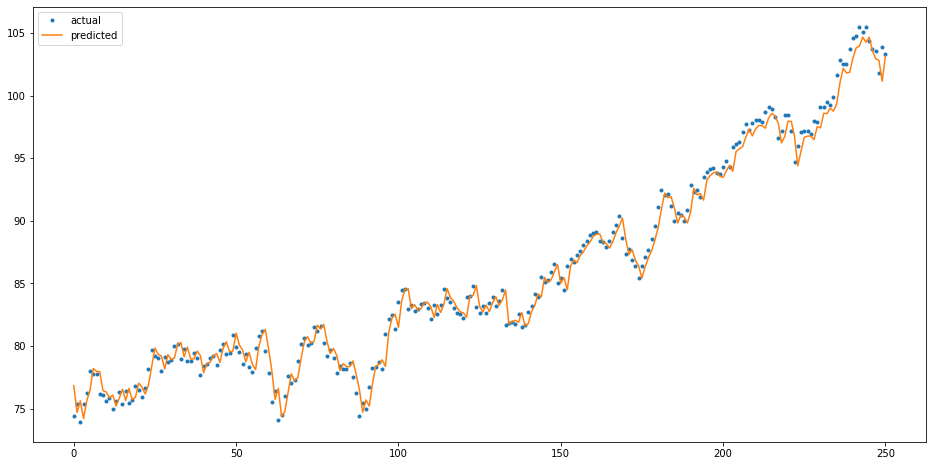

MAE: 0.8088
RMSE: 1.0025
R^2: 0.9856


In [ ]:
unit_model(train_scale, test_scale, time_step=1, unit=100)

3958/3958 [==============================] - 25s 5ms/step - loss: 0.0017


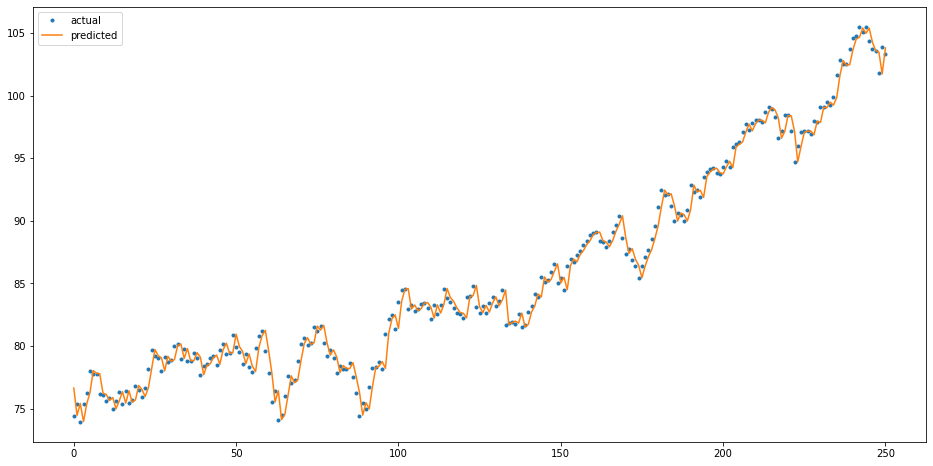

MAE: 0.7624
RMSE: 0.9537
R^2: 0.9870


In [ ]:
unit_model(train_scale, test_scale, time_step=1, unit=200)

3958/3958 [==============================] - 36s 9ms/step - loss: 0.0013


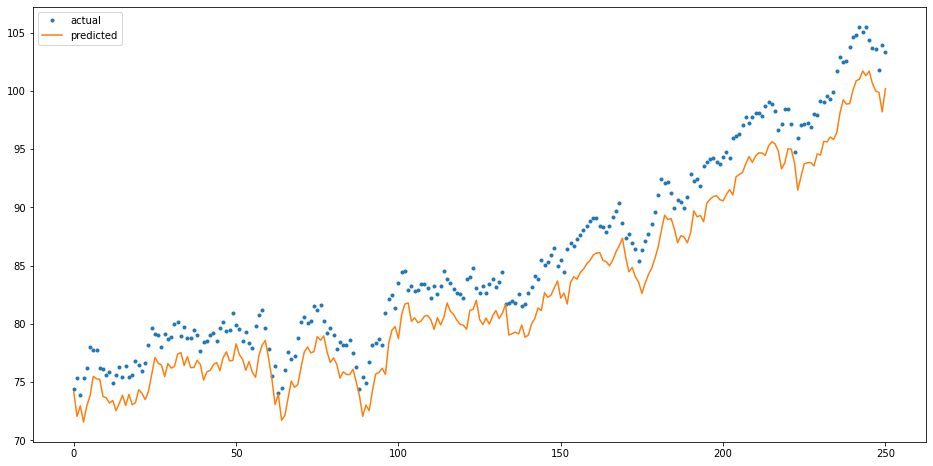

MAE: 2.9456
RMSE: 3.1174
R^2: 0.8611


In [ ]:
unit_model(train_scale, test_scale, time_step=1, unit=300)

In [ ]:
def dropout_model (train_set, test_set, dp):
  X_train, y_train = train_test_split(train_set, timestep=1)
  X_test, y_test = train_test_split(test_set, timestep=1)

  model = Sequential()
  model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1:])))
  model.add(Dropout(dp))
  model.add(LSTM(200))
  model.add(Dense(units=1))

  model.compile(optimizer='adam', loss='mean_squared_error')
  
  model.fit(X_train, y_train, batch_size=1, epochs=1)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  y_train_inv = scaler.inverse_transform(y_train_pred)
  y_test_inv = scaler.inverse_transform(y_test_pred)

  y_true = scaler.inverse_transform(y_test)

  plt.figure(figsize=(16,8))
  plt.plot(y_true, '.')
  plt.plot(y_test_inv)
  plt.legend(['actual', 'predicted'])
  plt.show()

  return ut.evaluate(y_true, y_test_inv)

3958/3958 [==============================] - 25s 5ms/step - loss: 0.0023


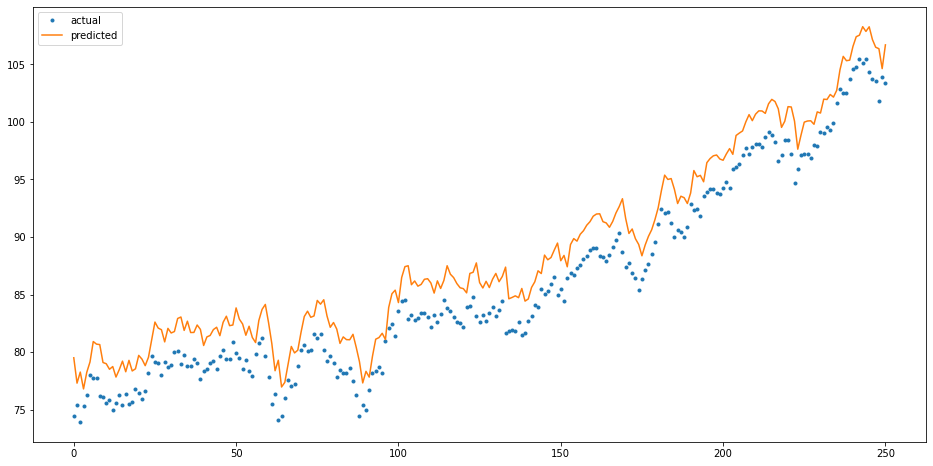

MAE: 2.8076
RMSE: 2.9639
R^2: 0.8745


In [ ]:
dropout_model(train_scale, test_scale, dp=0.2)

3958/3958 [==============================] - 25s 6ms/step - loss: 0.0026


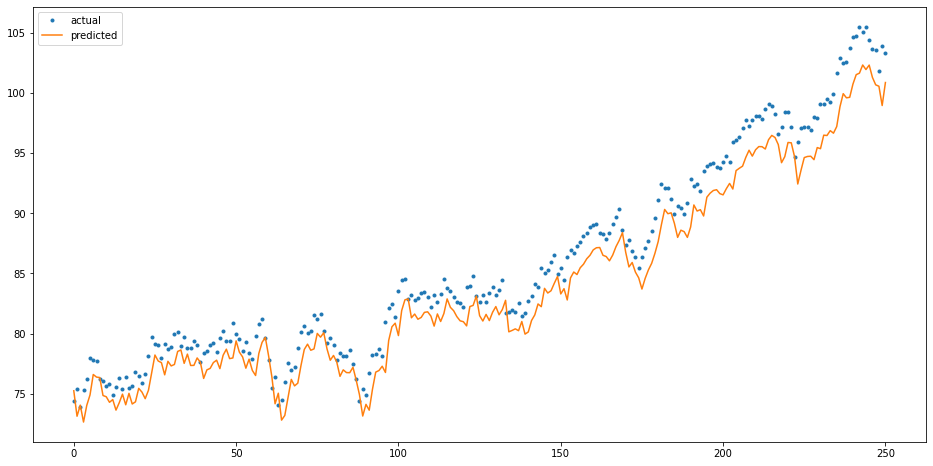

MAE: 1.9472
RMSE: 2.1858
R^2: 0.9317


In [ ]:
dropout_model(train_scale, test_scale, dp=0.5)

In [ ]:
def layer2_model (train_set, test_set):
  X_train, y_train = train_test_split(train_set, timestep=1)
  X_test, y_test = train_test_split(test_set, timestep=1)

  model = Sequential()
  model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1:])))
  model.add(LSTM(units=100, return_sequences=True))
  model.add(LSTM(100))
  model.add(Dense(units=1))

  model.compile(optimizer='adam', loss='mean_squared_error')
  
  model.fit(X_train, y_train, batch_size=1, epochs=1)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  y_train_inv = scaler.inverse_transform(y_train_pred)
  y_test_inv = scaler.inverse_transform(y_test_pred)

  y_true = scaler.inverse_transform(y_test)

  plt.figure(figsize=(16,8))
  plt.plot(y_true, '.')
  plt.plot(y_test_inv)
  plt.legend(['actual', 'predicted'])
  plt.show()

  return ut.evaluate(y_true, y_test_inv)

3958/3958 [==============================] - 26s 6ms/step - loss: 0.0020


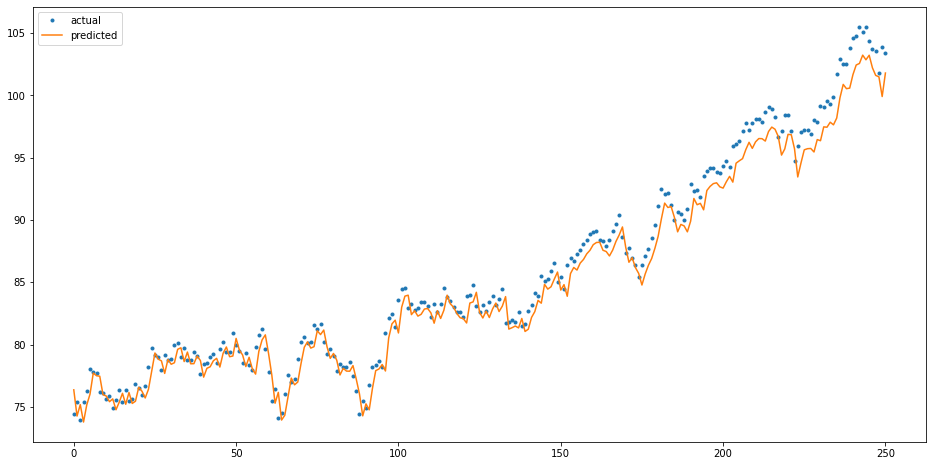

MAE: 1.1454
RMSE: 1.3835
R^2: 0.9726


In [ ]:
layer2_model(train_scale, test_scale)

In [ ]:
def layer3_model (train_set, test_set):
  X_train, y_train = train_test_split(train_set, timestep=1)
  X_test, y_test = train_test_split(test_set, timestep=1)

  model = Sequential()
  model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1:])))
  model.add(LSTM(units=100, return_sequences=True))
  model.add(LSTM(units=50, return_sequences=True))
  model.add(LSTM(50))
  model.add(Dense(units=1))

  model.compile(optimizer='adam', loss='mean_squared_error')
  
  model.fit(X_train, y_train, batch_size=1, epochs=1)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  y_train_inv = scaler.inverse_transform(y_train_pred)
  y_test_inv = scaler.inverse_transform(y_test_pred)

  y_true = scaler.inverse_transform(y_test)

  plt.figure(figsize=(16,8))
  plt.plot(y_true, '.')
  plt.plot(y_test_inv)
  plt.legend(['actual', 'predicted'])
  plt.show()

  return ut.evaluate(y_true, y_test_inv)

3958/3958 [==============================] - 30s 6ms/step - loss: 0.0022


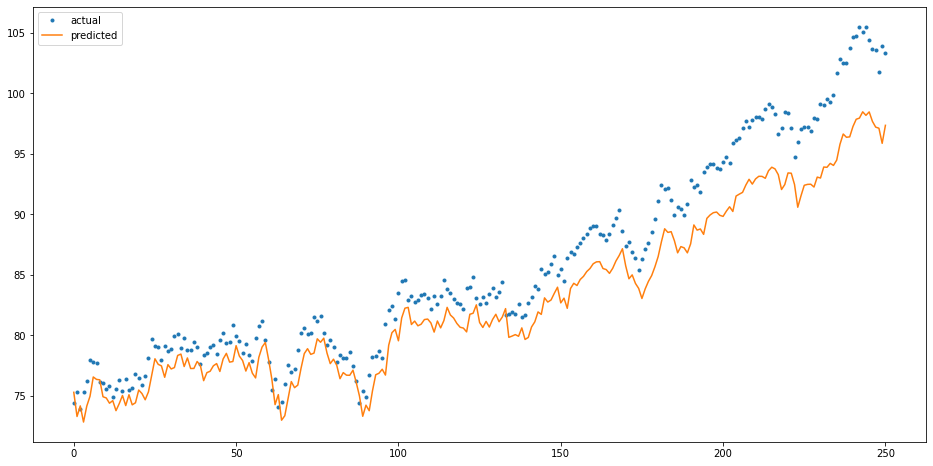

MAE: 2.8094
RMSE: 3.2994
R^2: 0.8444


In [ ]:
layer3_model(train_scale, test_scale)

In [ ]:
# model.save('/content/name.h5')
# model.load('/content/name.h5')

In [ ]:
X_train

(3937, 22, 1)